Driver Drowsiness Detection using CNN-LSTM model by Nadine Maysaud

Acknowledgement - Implementing pretrained model based off of this code: https://www.kaggle.com/code/esraameslamsayed/driver-drowsiness-detection-cnn-mobilenetv2

In [1]:
#importing 
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator as data_augment
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Flatten,Dense,GlobalAveragePooling2D,BatchNormalization,TimeDistributed,LSTM
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras import layers as layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import classification_report
from collections import Counter
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model


# keras.applications.ResNet50V2(
#     include_top=True,
#     weights='imagenet',
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation='softmax'
# )

2025-03-21 00:17:00.625935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 00:17:00.626099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 00:17:00.777605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install split-folders

In [3]:
import splitfolders
data_d = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)'
output_d = '/kaggle/working/splitted_Data'
splitfolders.ratio(data_d, output=output_d, seed=1942, ratio=(.8, .15, .05))

Copying files: 41793 files [04:58, 140.10 files/s]


In [4]:
traind = "/kaggle/working/splitted_Data/train"
testd = "/kaggle/working/splitted_Data/test"
vald = "/kaggle/working/splitted_Data/val"

In [5]:
train_datagen = data_augment(rescale=1./255)
test_datagen = data_augment(rescale=1./255)
val_datagen = data_augment(rescale=1./255)

In [6]:
train_batches = train_datagen.flow_from_directory(
    traind,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)
test_batches = test_datagen.flow_from_directory(
    testd,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary' ,
    shuffle=True
)
val_batches = val_datagen.flow_from_directory(
    vald,
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

Found 33434 images belonging to 2 classes.
Found 2091 images belonging to 2 classes.
Found 6268 images belonging to 2 classes.


In [7]:
train_class_indices = train_batches.class_indices
test_class_indices = test_batches.class_indices
val_class_indices = val_batches.class_indices

train_class_labels = train_batches.classes
test_class_labels = test_batches.classes
val_class_labels = val_batches.classes


train_class_counts = Counter(train_class_labels)
test_class_counts = Counter(test_class_labels)
val_class_counts = Counter(val_class_labels)

print("Class Names for train:\n", train_class_indices)
print("Class Counts for train:\n", train_class_counts)
print(end='\n')

print("Class Names for test:\n", test_class_indices)
print("Class Counts for test:\n", test_class_counts)
print(end='\n')

print("Class Names for validation :\n", val_class_indices)
print("Class Counts for validation:\n", val_class_counts)

Class Names for train:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for train:
 Counter({0: 17878, 1: 15556})

Class Names for test:
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for test:
 Counter({0: 1118, 1: 973})

Class Names for validation :
 {'Drowsy': 0, 'Non Drowsy': 1}
Class Counts for validation:
 Counter({0: 3352, 1: 2916})


Pixels of the first image after Normalization: 

[[[0.94117653 0.87843144 0.78823537]
  [0.9294118  0.86666673 0.7803922 ]
  [0.9450981  0.87843144 0.79215693]
  ...
  [0.56078434 0.5019608  0.4039216 ]
  [0.81568635 0.7490196  0.65882355]
  [0.9333334  0.86274517 0.77647066]]

 [[0.9490197  0.8862746  0.79215693]
  [0.94117653 0.882353   0.78823537]
  [0.94117653 0.87843144 0.7843138 ]
  ...
  [0.52156866 0.46274513 0.3647059 ]
  [0.8117648  0.75294125 0.65882355]
  [0.91372555 0.83921576 0.7490196 ]]

 [[0.9490197  0.8862746  0.79215693]
  [0.95294124 0.89019614 0.7960785 ]
  [0.9490197  0.8862746  0.79215693]
  ...
  [0.4901961  0.427451   0.33333334]
  [0.7960785  0.73333335 0.6392157 ]
  [0.8862746  0.8117648  0.72156864]]

 ...

 [[0.20784315 0.07450981 0.03137255]
  [0.20392159 0.07450981 0.03137255]
  [0.20392159 0.08235294 0.03529412]
  ...
  [0.20784315 0.05882353 0.06666667]
  [0.23137257 0.07058824 0.08235294]
  [0.25882354 0.09019608 0.09411766]]

 [[0.20392159 0.07450981 

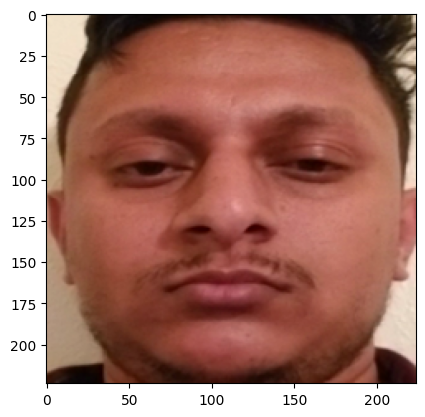

In [8]:
images, labels = next(train_batches)
print(f"Pixels of the first image after Normalization: \n\n{images[0]}") #print pixels of the first img
plt.imshow(images[0])
plt.show()

In [9]:
print(f"there are { images[0].ndim} Channels ")
print(f"image shape : {images[0].shape}")

there are 3 Channels 
image shape : (224, 224, 3)


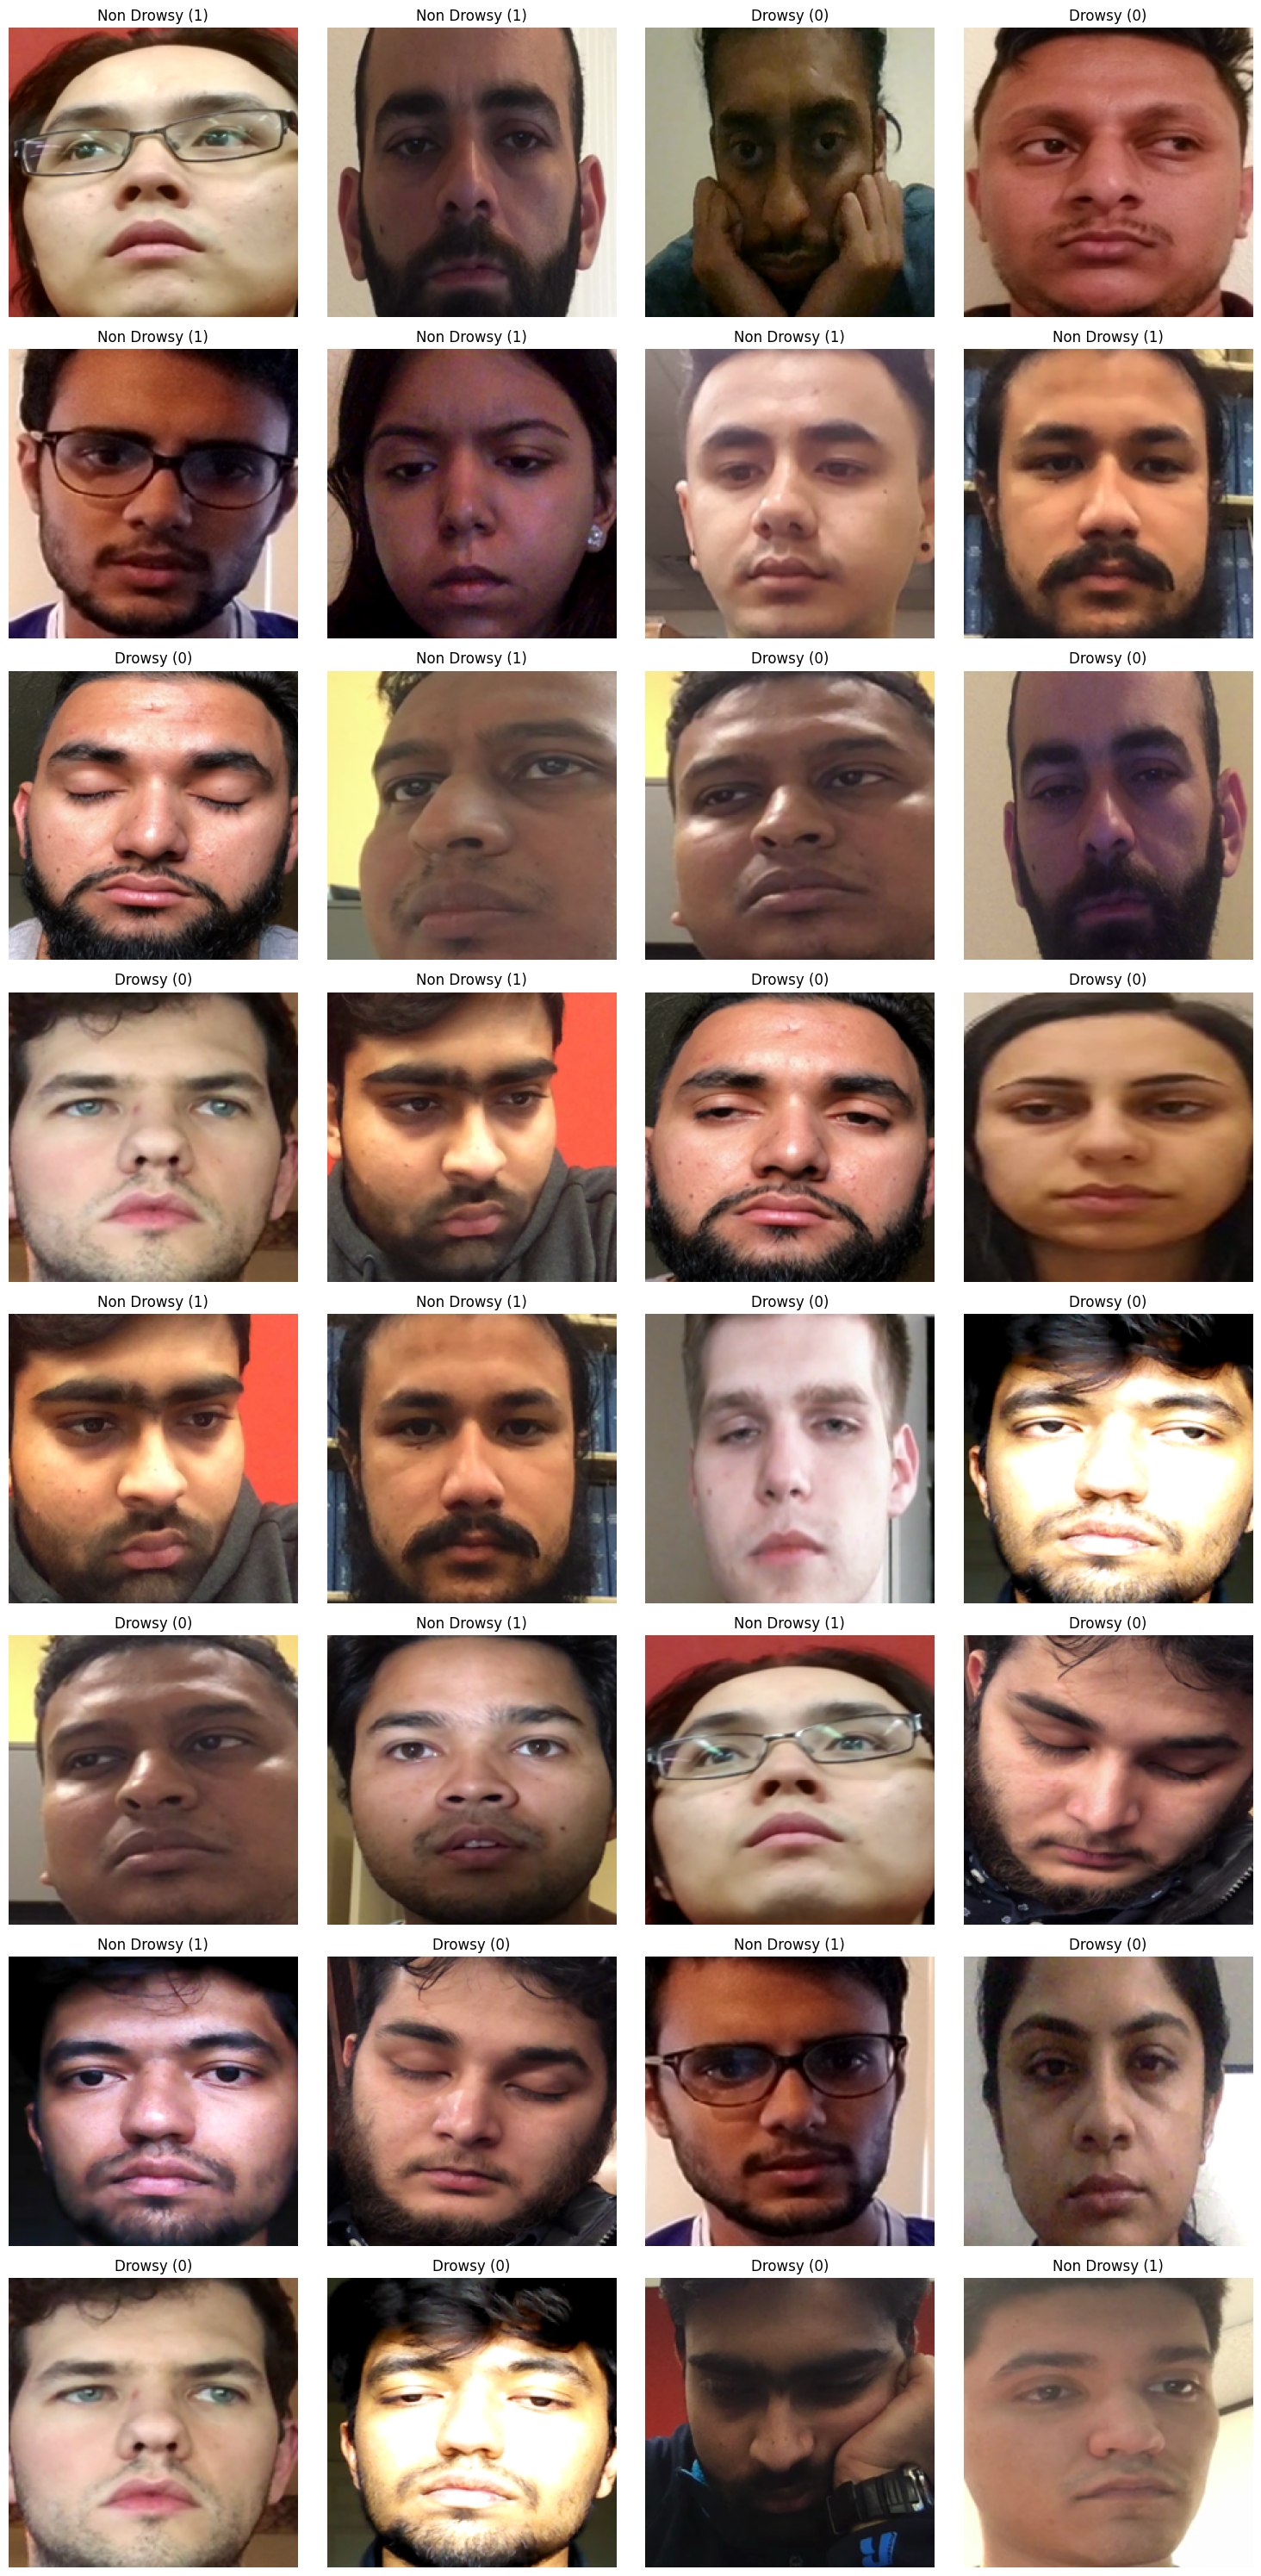

In [10]:
fig, axes = plt.subplots(8, 4, figsize=(15, 30))
class_indices = train_batches.class_indices

for i in range(8):
    images, labels = next(train_batches)
    for j in range(4):
        
        ax = axes[i, j]
        ax.imshow(images[j])
        ax.axis('off')
        label = int(labels[j])  
        label_name = list(class_indices.keys())[list(class_indices.values()).index(label)]
        ax.set_title(f'{label_name} ({label})')

plt.tight_layout()
plt.show()

In [11]:
model_base = keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape = (224, 224, 3)
)
model_base.trainable=False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
model_base.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [13]:

x = model_base.output
x = TimeDistributed(Flatten())(x)
x = LSTM(128, return_sequences=True)(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(512, activation = 'relu')(x)
x = Flatten()(x)
preds = Dense(2, activation='softmax')(x)
CNNLSTM = Model(inputs=model_base.input, outputs=preds)



In [14]:
CNNLSTM.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 31,634,946 (120.68 MB)

 Trainable params: 8,070,146 (30.79 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
CNNLSTM.compile(optimizer=Adam(0.0001),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [16]:
history = CNNLSTM.fit(train_batches, epochs = 10, validation_data = val_batches, batch_size=32)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2090/2090 ━━━━━━━━━━━━━━━━━━━━ 175s 78ms/step - accuracy: 0.9786 - loss: 0.0536 - val_accuracy: 0.9998 - val_loss: 9.2143e-04
Epoch 2/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 161s 77ms/step - accuracy: 0.9999 - loss: 4.4968e-04 - val_accuracy: 1.0000 - val_loss: 8.2996e-05
Epoch 3/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 163s 78ms/step - accuracy: 0.9998 - loss: 7.7127e-04 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 4/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 159s 76ms/step - accuracy: 0.9997 - loss: 8.0926e-04 - val_accuracy: 0.9998 - val_loss: 1.6845e-04
Epoch 5/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 160s 76ms/step - accuracy: 1.0000 - loss: 2.4582e-05 - val_accuracy: 0.9998 - val_loss: 1.8429e-04
Epoch 6/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 159s 76ms/step - accuracy: 1.0000 - loss: 6.2388e-07 - val_accuracy: 1.0000 - val_loss: 1.3257e-04
Epoch 7/10
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 156s 74ms/step - accuracy: 1.0000 - loss: 1.4477e-07 - val_accuracy: 1.0000 - val_loss: 1.1422e-04
Epoch 8/10
2090/2090 ━━━━━━━━━━━

In [17]:
train_loss, train_acc = CNNLSTM.evaluate(train_batches)

2090/2090 ━━━━━━━━━━━━━━━━━━━━ 125s 60ms/step - accuracy: 1.0000 - loss: 6.3265e-09


In [18]:
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_acc*100:.2f}%")

Training Loss: 0.0000
Training Accuracy: 100.00%


In [19]:
test_loss, test_accuracy = CNNLSTM.evaluate(test_batches)

131/131 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 1.0000 - loss: 2.7870e-05


In [20]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Loss: 0.0002
Test Accuracy: 100.00%


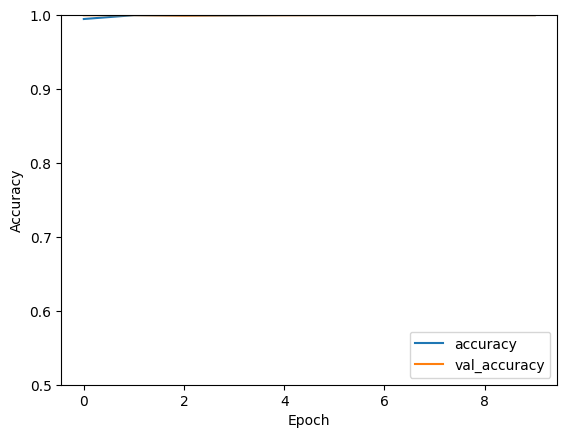

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')


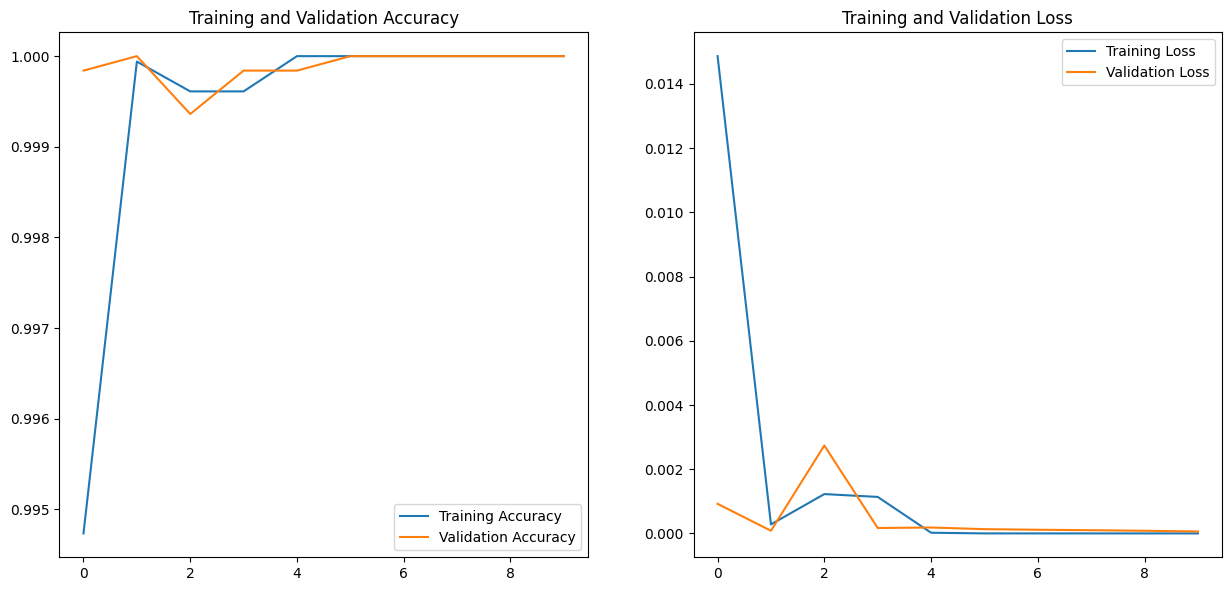

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


Text(0, 0.5, 'Loss')

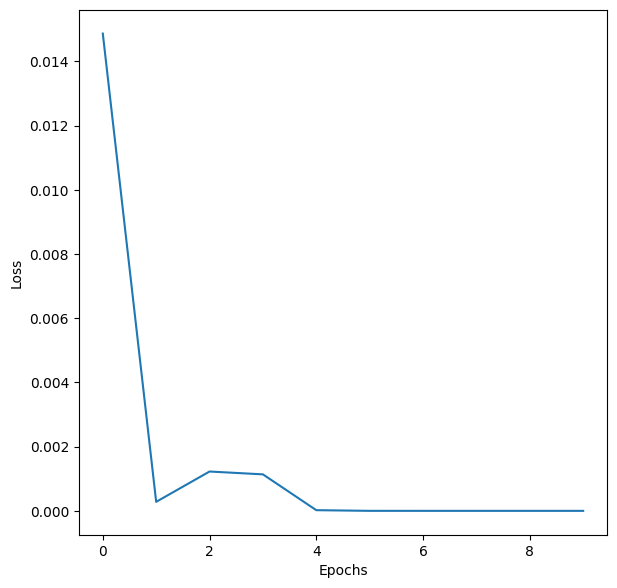

In [23]:
loss = history.history['loss']
epochs_range = range(10)
plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, loss, label='loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [25]:
CNNLSTM.save('cnn_lstm1.h5')